<a href="https://colab.research.google.com/github/aldojda/BigData/blob/main/LSTM_proyectoFinal" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
pip install keras_preprocessing

In [117]:
import unicodedata
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.utils import to_categorical
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#Modelo de Análisis de Sentimiento

## Tratamiento de datos

teniendo ya preprocesados los datos leemos la información almacenada en un csv file procedente del web-scrapping de la página de mis profesores. Enseguida procedemos a la lectura de la información y limpieza de datos

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
!ls "drive/MyDrive/01 - Maestría Ciencia de Datos/ProyectoSentiment-AnalysisFCFM"

cat_profesores.csv		     LSTM-Sentiment  mis_profesores_data.csv
datos_FCFM_misprofesores_250723.csv  materias.csv    WebScrapping


In [120]:
import pandas as pd
df = pd.read_csv("drive/MyDrive/01 - Maestría Ciencia de Datos/ProyectoSentiment-AnalysisFCFM/mis_profesores_data.csv")
df.head(1)

,materia,obligatoria,calificacion_alumno,interes,commentario,calidad_general,facilidad,date,clean_comments,profesor_,genero,materia_clean,materia_clase,mes,anno,date_
0,Administración del Riesgo Empresarial Aplicada,No obligatoria,10.0,Bajo,"Realmente no de clase, rep...",9.0,10.0,03/Mar/2022,realmente no de clase reparte los temas entre ...,azucena rios,female,administracin del riesgo empresarial aplicada,administracion,3,2022,2022-03-01


In [121]:
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [122]:
df["clean_comment"] = df.commentario.apply(lambda x: strip_accents(x).lower().translate(str.maketrans("", "", string.punctuation)))
df["NPS"] = np.where(df.calidad_general >= 9, "positivo", np.where(df.calidad_general >= 7, "neutro", "negativo"))
df["NPS"] = np.where(df.calidad_general >= 8, "positivo", "negativo")
df["NPS"].value_counts(normalize = True)

positivo    0.594663
negativo    0.405337
Name: NPS, dtype: float64

In [123]:
# The sum of the weights of all examples stays the same.
pos, neg, total = 2622, 1313, 3935
weight_for_negative = (1 / neg) * (total / 2.0)
weight_for_positive = (1 / pos) * (total / 2.0)

class_weight = {1: weight_for_negative, 0: weight_for_positive}
class_weight

{1: 1.4984767707539985, 0: 0.7503813882532419}

## Entrenamiento de datos positivos y negativos

### Transformer

In [124]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

#
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

#Función que permite visualizar las métricas
def plot_metrics(history):
  metrics = ["loss", "accuracy", 'auc', 'recall']#['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()

    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [125]:
# Codificar las etiquetas de clase
class_mapping = {"positivo": 0, "negativo":1}
df['NPS_'] = df['NPS'].map(class_mapping)

# Tokenizar los comentarios
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_comment'])
X = tokenizer.texts_to_sequences(df['clean_comment'])
X = pad_sequences(X)
y = to_categorical(df['NPS_'], num_classes = 2)

# Paso 2: Crear conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [126]:
maxlen = 200  # Only consider the first 200 words of each movie review
vocab_size = 20000
x_train = keras.utils.pad_sequences(X_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(X_val, maxlen=maxlen)

In [127]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [128]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=6,
    mode='max',

    restore_best_weights=True)

In [129]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')]

In [130]:
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=METRICS)

history = model.fit(
    x_train, y_train, batch_size=32, epochs=23, callbacks=[early_stopping],  validation_data=(x_val, y_val), class_weight=class_weight
)
evaluations = model.evaluate(X_test, y_test)

Epoch 1/23
99/99 [==============================] - 4s 17ms/step - loss: 0.7624 - accuracy: 0.4682 - precision: 0.4682 - recall: 0.4682 - auc: 0.4603 - val_loss: 0.7429 - val_accuracy: 0.3959 - val_precision: 0.3959 - val_recall: 0.3959 - val_auc: 0.4034
Epoch 2/23
99/99 [==============================] - 2s 18ms/step - loss: 0.7339 - accuracy: 0.4377 - precision: 0.4377 - recall: 0.4377 - auc: 0.4288 - val_loss: 0.7117 - val_accuracy: 0.3959 - val_precision: 0.3959 - val_recall: 0.3959 - val_auc: 0.3977
Epoch 3/23
99/99 [==============================] - 2s 16ms/step - loss: 0.7278 - accuracy: 0.4298 - precision: 0.4298 - recall: 0.4298 - auc: 0.4210 - val_loss: 0.7045 - val_accuracy: 0.3959 - val_precision: 0.3959 - val_recall: 0.3959 - val_auc: 0.3977
Epoch 4/23
99/99 [==============================] - 2s 23ms/step - loss: 0.7243 - accuracy: 0.4292 - precision: 0.4292 - recall: 0.4292 - auc: 0.4270 - val_loss: 0.7038 - val_accuracy: 0.3959 - val_precision: 0.3959 - val_recall: 0.395

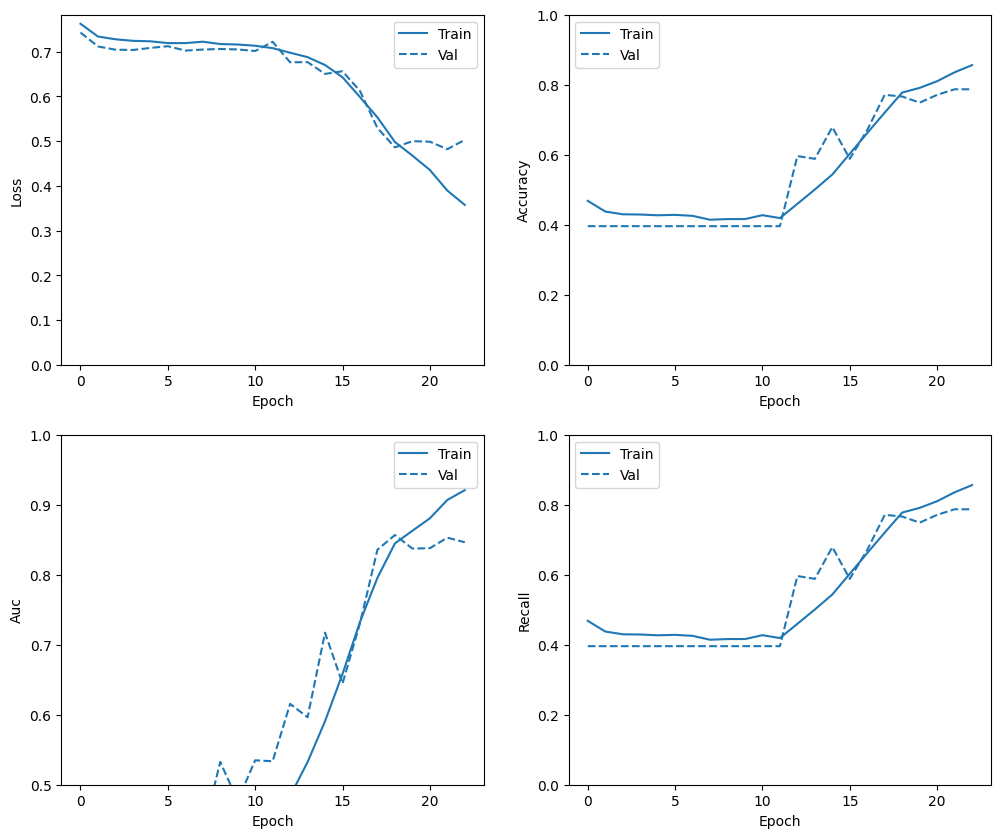

In [131]:
plot_metrics(history)

In [132]:
from sklearn.metrics import classification_report

y_true = y_test[:,0]
X_test_ = keras.utils.pad_sequences(X_test, maxlen=maxlen)
y_pred = model.predict(X_test_)[:,0].round()

print(classification_report(y_true, y_pred))

5/5 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83        73
         1.0       0.87      0.81      0.84        85

    accuracy                           0.84       158
   macro avg       0.84      0.84      0.84       158
weighted avg       0.84      0.84      0.84       158



### Sentiment Analysis

In [135]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience = 5,
    mode='max',
    restore_best_weights=True)

In [136]:
# Paso 3: Definir y entrenar la red LSTM
embedding_dim = 500
vocab_size = len(tokenizer.word_index) + 1
max_length = X.shape[1]
from keras.regularizers import l2
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.3, kernel_regularizer=l2(0.03)))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=METRICS)

baseline_history = model.fit(X_train, y_train, batch_size=128, epochs=10, callbacks=[early_stopping], validation_data=(X_val, y_val), class_weight=class_weight)

# Paso 4: Evaluar el modelo en el conjunto de prueba
evaluations = model.evaluate(X_test, y_test)
#print(f'Test loss: {loss}, Test accuracy: {accuracy}')

Epoch 1/10
25/25 [==============================] - 13s 409ms/step - loss: 10.3800 - accuracy: 0.4307 - precision: 0.4307 - recall: 0.4307 - auc: 0.4725 - val_loss: 5.7484 - val_accuracy: 0.3959 - val_precision: 0.3959 - val_recall: 0.3959 - val_auc: 0.5216
Epoch 2/10
25/25 [==============================] - 10s 388ms/step - loss: 3.5741 - accuracy: 0.5619 - precision: 0.5619 - recall: 0.5619 - auc: 0.6123 - val_loss: 2.0316 - val_accuracy: 0.5453 - val_precision: 0.5453 - val_recall: 0.5453 - val_auc: 0.5817
Epoch 3/10
25/25 [==============================] - 7s 289ms/step - loss: 1.2821 - accuracy: 0.7157 - precision: 0.7157 - recall: 0.7157 - auc: 0.7803 - val_loss: 0.8614 - val_accuracy: 0.7472 - val_precision: 0.7472 - val_recall: 0.7472 - val_auc: 0.8103
Epoch 4/10
25/25 [==============================] - 9s 382ms/step - loss: 0.6240 - accuracy: 0.7891 - precision: 0.7891 - recall: 0.7891 - auc: 0.8697 - val_loss: 0.5694 - val_accuracy: 0.7822 - val_precision: 0.7822 - val_recall

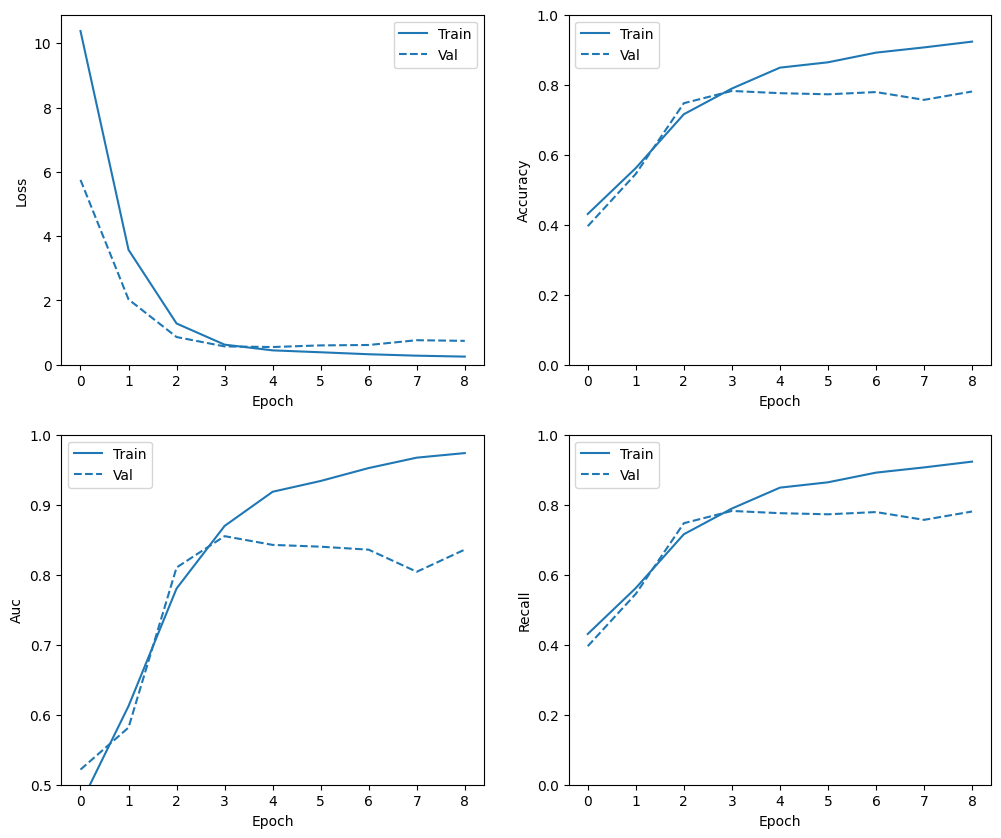

In [137]:
plot_metrics(baseline_history)

In [138]:
from sklearn.metrics import classification_report

y_true = y_test[:,0]
#X_test = keras.utils.pad_sequences(X_test, maxlen=maxlen)
y_pred = model.predict(X_test)[:,0].round()

print(classification_report(y_true, y_pred))

5/5 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78        73
         1.0       0.81      0.84      0.82        85

    accuracy                           0.80       158
   macro avg       0.80      0.80      0.80       158
weighted avg       0.80      0.80      0.80       158

